## Setup

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt

import soundfile as sf
import IPython
from scipy.io.wavfile import read
from scipy.io import wavfile
from pydub import AudioSegment,effects
import librosa.display
import noisereduce as nr

import os
import io

import random

c:\ProgramData\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = []
y = []

for i in os.listdir('mixed'):
  clean, _ = sf.read("clean/" + i)
  noisy, _ = sf.read("mixed/" + i)
  X.append(clean)
  y.append(noisy)

In [11]:
len(X[0])

2070

In [3]:
set_len = 1800
train_data = X[:set_len]
test_data = X[set_len:]
noisy_train_data = y[:set_len]
noisy_test_data = y[set_len:]

## Build the autoencoder

In [ ]:
input = layers.Input(shape=(80000,1))

# Encoder
conv1 = layers.Conv1D(32, 3, padding="same")(input)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation('relu')(conv1)
conv1 = layers.MaxPooling1D(3, strides =  2, padding="same")(conv1)

conv2 = layers.Conv1D(64, 3, padding="same")(conv1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.Activation('relu')(conv2)
conv2 = layers.MaxPooling1D(3, strides = 2, padding="same")(conv2)

conv3 = layers.Conv1D(128, 3, padding="same")(conv2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Activation('relu')(conv3)
conv3 = layers.MaxPooling1D(3, strides = 2, padding="same")(conv3)

# Decoder

x = layers.Conv1DTranspose(128, 3, strides=2, activation="relu", padding="same")(conv3)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv1DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv1DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv1D(1, 3, activation="tanh", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

In [ ]:
keras.utils.plot_model(autoencoder, show_shapes=True)

## Predictions

In [4]:
def model_ready(x):
  x = np.array(x)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  return x

In [6]:
noisy_test_data = model_ready(noisy_test_data)
noisy_train_data = model_ready(noisy_train_data)
test_data = model_ready(test_data)
train_data = model_ready(train_data)

In [21]:
noisy_test_data.shape

(70, 80000, 1)

In [22]:
train_data.shape

(2000, 80000, 1)

In [23]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/20
 9/63 [===>..........................] - ETA: 9:27 - loss: 0.0031

KeyboardInterrupt: 

In [ ]:
def plot_learning_curve(history: dict, metrics_name: list):
    for metric in metrics_name:
        plt.figure()
        plt.plot(history.get(metric), label=metric)
        plt.plot(history.get(f'val_{metric}'), label=f'val_{metric}')
        plt.xlabel('epoch')
        plt.xlabel(metric)
        plt.legend()
        plt.show()

plot_learning_curve(conv.history.history, ['loss'])

In [ ]:
model.save('denoiser_model')

In [11]:
prediction = autoencoder.predict(noisy_test_data)

ValueError: in user code:

    File "C:\Users\Charles Belpois\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Charles Belpois\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Charles Belpois\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Charles Belpois\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\Charles Belpois\AppData\Roaming\Python\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Charles Belpois\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 80000, 1), found shape=(32, 1, 1)


## Denoising

In [8]:
model = tf.keras.models.load_model(r'denoiser_model')

In [16]:
i = 20
test_dir = "test/"
sf.write(f'{test_dir}noisy_test{i}.wav', noisy_test_data[i], 16000)
sf.write(f'{test_dir}pred_test{i}.wav', prediction[i], 16000)
sf.write(f'{test_dir}clean_test{i}.wav', test_data[i], 16000)

rate, data = wavfile.read(f"{test_dir}noisy_test{i}.wav")
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write(f"{test_dir}baseline_test{i}.wav", rate, reduced_noise)

rate, data = wavfile.read(f"{test_dir}pred_test{i}.wav")
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write(f"{test_dir}pred_final{i}.wav", rate, reduced_noise)

LibsndfileError: Error opening 'test/noisy_test20.wav': System error.

In [ ]:
IPython.display.Audio(f'{test_dir}noisy_test{i}.wav')

In [ ]:
IPython.display.Audio(f'{test_dir}pred_test{i}.wav')

In [ ]:
IPython.display.Audio(f'{test_dir}clean_test{i}.wav')

In [ ]:
IPython.display.Audio(f'{test_dir}basline_test{i}.wav')

In [28]:
IPython.display.Audio(f'{test_dir}pred_final{i}.wav')

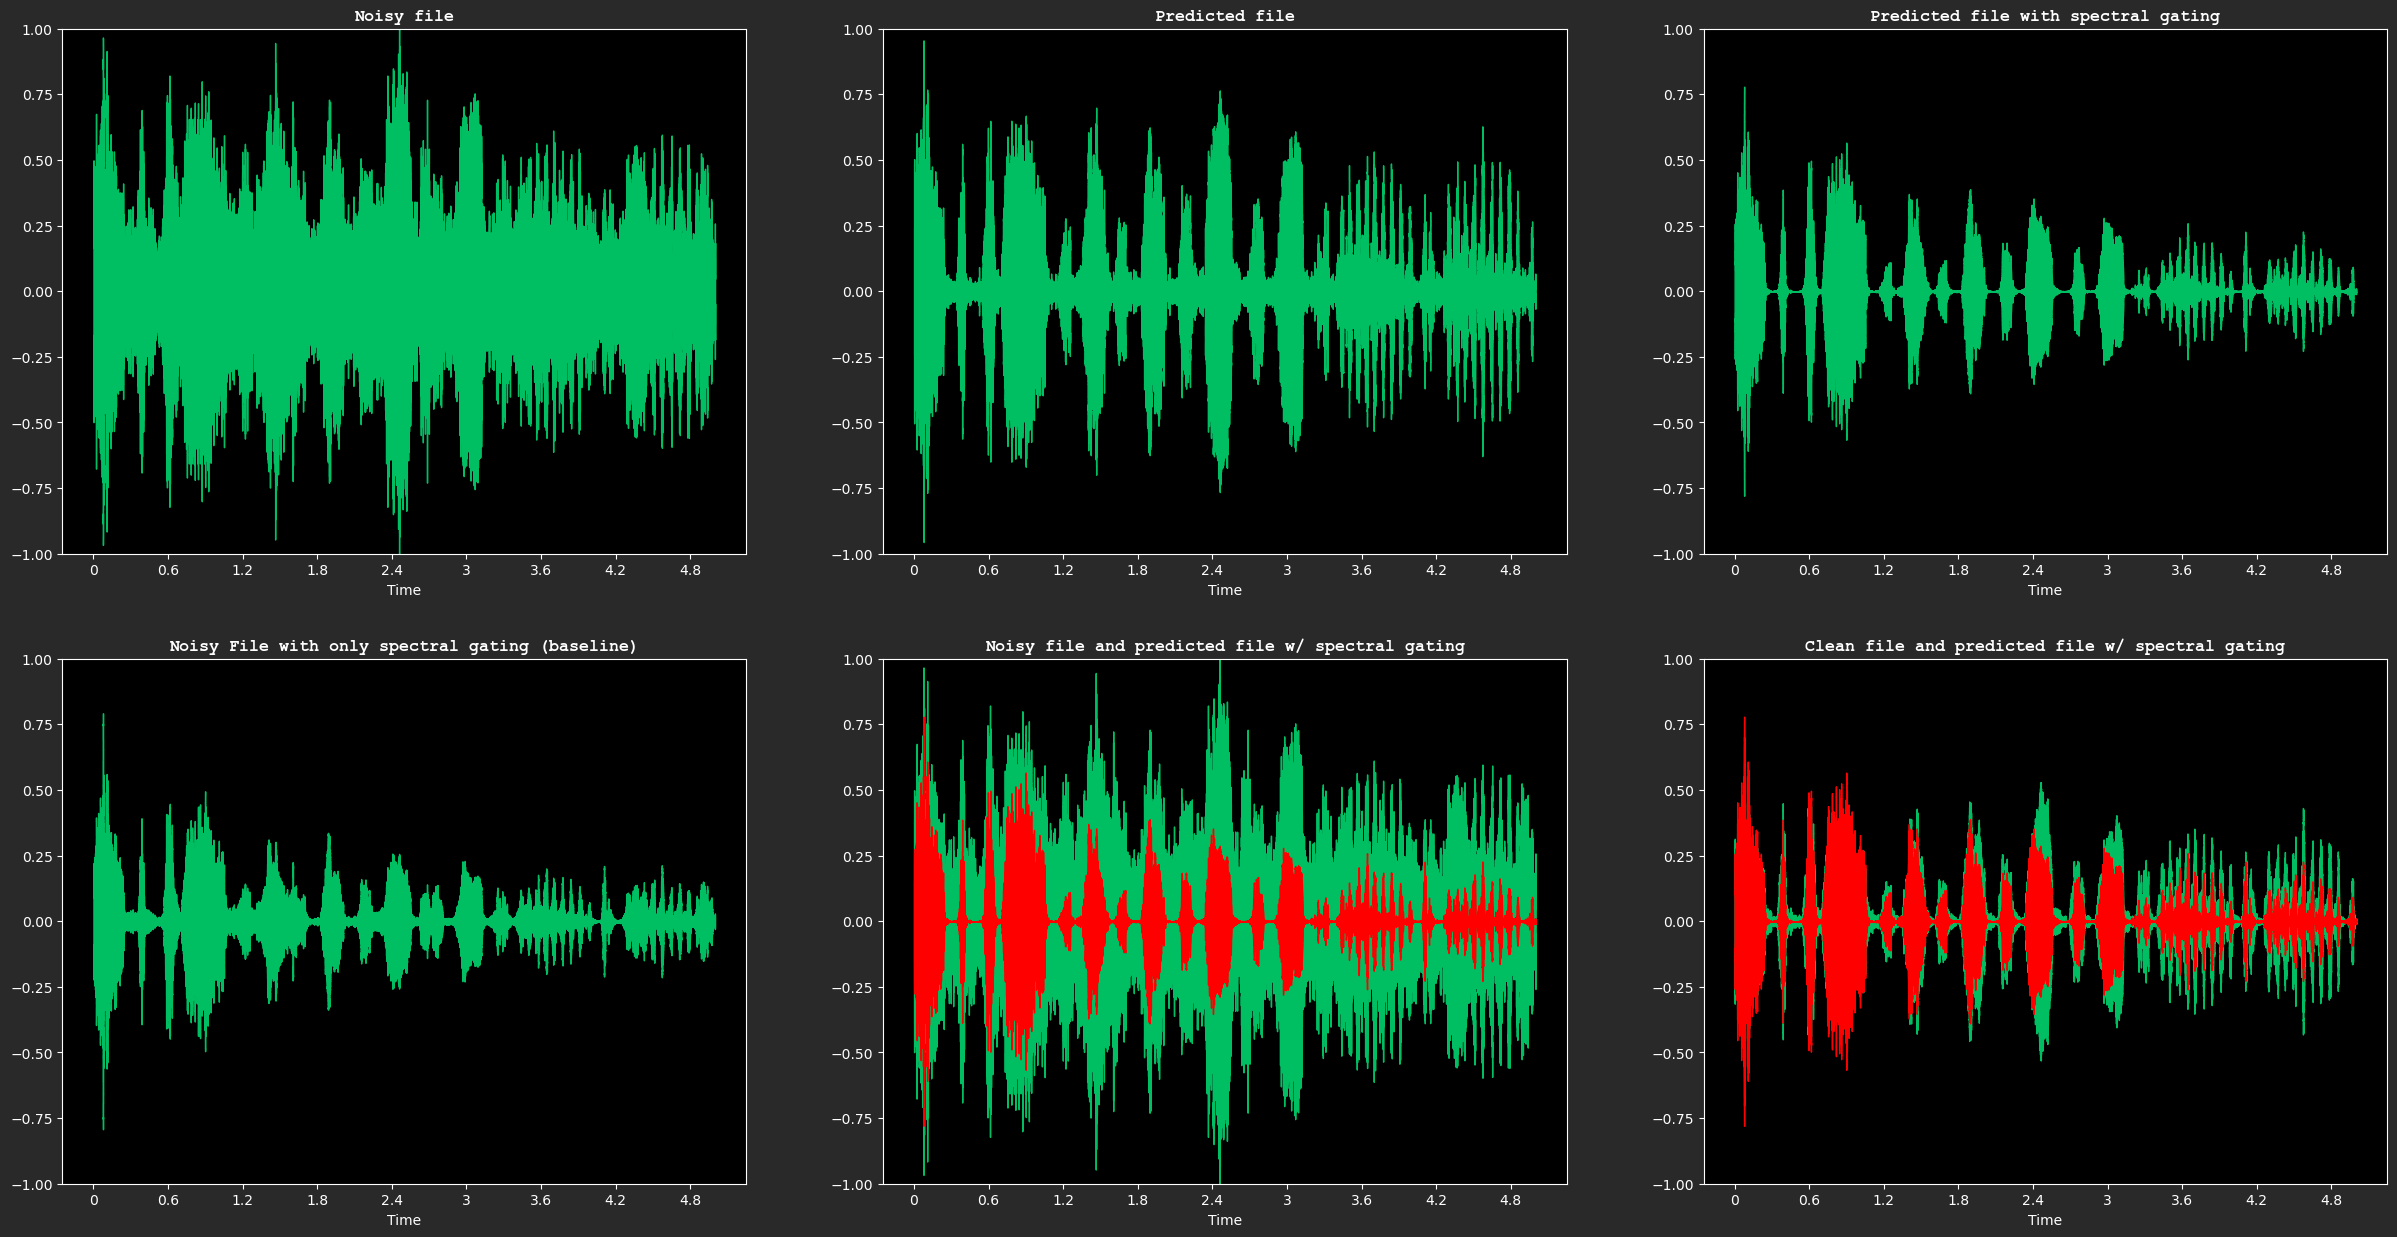

In [86]:
csfont = {'fontname':'Courier New'}
plt.style.use('dark_background')

i = 1
test_dir = "test/"

def over_imposed_waves(file1, file2, title):
    plt.axis(ymin=-1,ymax=1)
    plt.title(title,fontweight="bold", **csfont)

    j = librosa.load(file1, duration=5.)
    librosa.display.waveshow(j[0], sr=22050, color = '#00BF63')
    k = librosa.load(file2, duration=5.)
    librosa.display.waveshow(k[0], sr=22050, color = 'red')

plt.figure(figsize=(30,15), facecolor='#292929')


array = [f"{test_dir}noisy_test{i}.wav", f"{test_dir}pred_test{i}.wav", f"{test_dir}pred_final{i}.wav", f"{test_dir}baseline_test{i}.wav", f"{test_dir}clean_test{i}.wav"]
titles = ["Noisy file", "Predicted file", "Predicted file with spectral gating", "Noisy File with only spectral gating (baseline)"]
for i in range(4):
    plt.subplot(2, 3, i + 1)
    plt.axis(ymin=-1,ymax=1,)
    
    plt.title(titles[i], fontweight="bold", **csfont)
    j = librosa.load(array[i])
    librosa.display.waveshow(j[0], sr=22050, color = '#00BF63')

plt.subplot(2, 3, 5)
over_imposed_waves(array[0], array[2], "Noisy file and predicted file w/ spectral gating")

plt.subplot(2, 3, 6)
over_imposed_waves(array[4], array[2],"Clean file and predicted file w/ spectral gating")

plt.savefig("waveform_comparison_large.pdf")